# Deep Q-Learning (DQN) for Syariah Investment

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque
import random

2025-06-19 23:30:59.408893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Daily Data

In [2]:
# Load data
df = pd.read_csv("idx_shariah_daily.csv")

# Check Data
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,28-05-2025,226.01,227.56,227.92,225.89,13.33B,-0.08%
1,27-05-2025,226.19,226.24,226.52,225.33,12.23B,0.35%
2,26-05-2025,225.40,226.84,227.18,224.10,13.39B,-0.16%
3,23-05-2025,225.76,224.92,226.07,224.51,10.24B,0.65%
4,22-05-2025,224.32,224.16,225.47,223.85,12.58B,0.34%


In [3]:
# Rename columns for consistency
df.rename(columns={
    'Price': 'Close',
    'Vol.': 'Volume',
    'Change %': 'Change'
}, inplace=True)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Sort ascending
df = df.sort_values('Date').reset_index(drop=True)

# Clean Change (% → float)
df['Change'] = df['Change'].str.replace('%', '').astype(float)

# Convert Volume from string to number (e.g., 1.2B → 1_200_000_000)
def convert_volume(val):
    if isinstance(val, str):
        if 'B' in val:
            return float(val.replace('B', '')) * 1e9
        elif 'M' in val:
            return float(val.replace('M', '')) * 1e6
    return np.nan

df['Volume'] = df['Volume'].apply(convert_volume)

# Drop any rows with missing values
df.dropna(inplace=True)

# Check result
df.head()

,Date,Close,Open,High,Low,Volume,Change
0,2020-01-02,186.71,188.29,188.54,186.24,2.260000e+09,-0.54
1,2020-01-03,187.58,187.38,187.58,186.56,2.730000e+09,0.47
2,2020-01-06,185.35,186.99,187.20,185.31,2.520000e+09,-1.19
3,2020-01-07,185.65,185.53,186.17,184.65,2.410000e+09,0.16
4,2020-01-08,183.72,184.94,185.06,183.47,2.690000e+09,-1.04


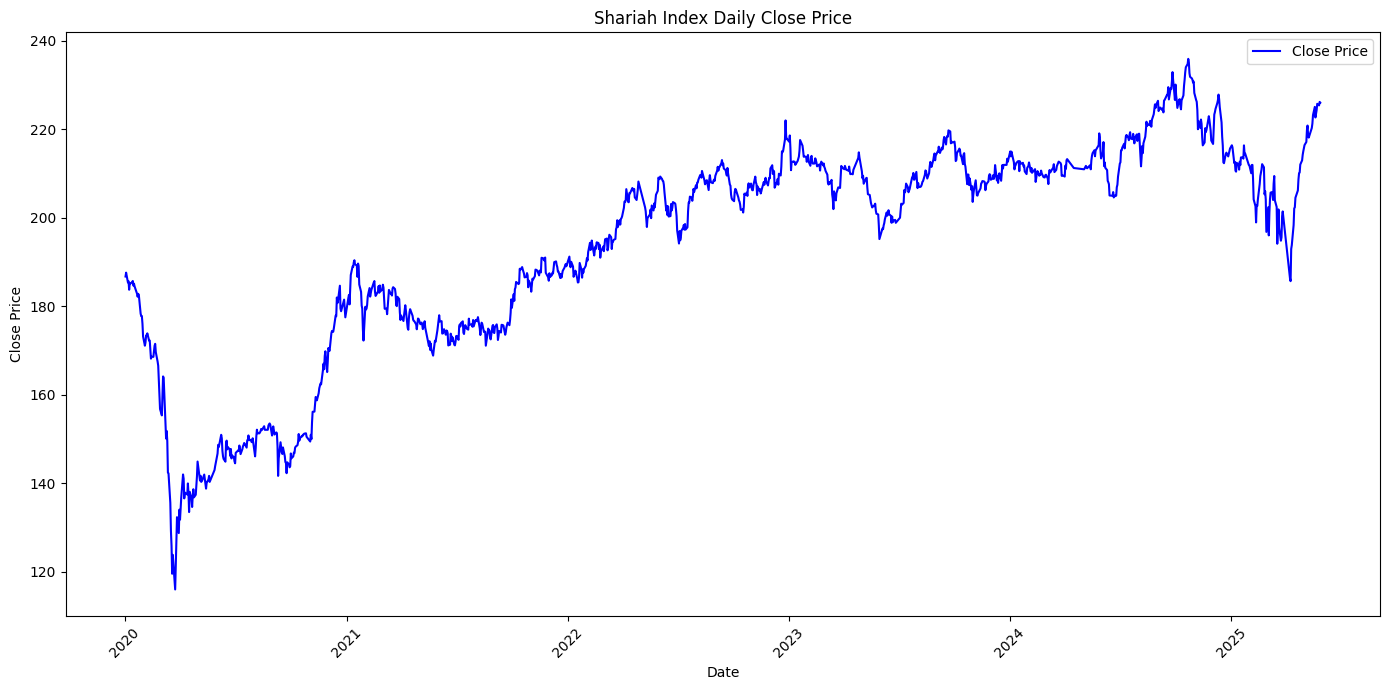

In [4]:
# Visualize the data by date
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('Shariah Index Daily Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Preprocessing (windowing, normalize, split data)

In [5]:
# Normalisasi hanya kolom numerik (kecuali Date)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Check the normalized data
df.head()

,Date,Close,Open,High,Low,Volume,Change
0,2020-01-02,0.589814,0.604496,0.587489,0.598783,0.016045,0.420133
1,2020-01-03,0.597066,0.596891,0.579206,0.601450,0.027135,0.481013
2,2020-01-06,0.578478,0.593632,0.575928,0.591030,0.022180,0.380952
3,2020-01-07,0.580979,0.581432,0.567041,0.585529,0.019585,0.462327
4,2020-01-08,0.564891,0.576502,0.557463,0.575692,0.026192,0.389994


In [6]:
# Fungsi untuk membuat data window
def create_window_data(df, window_size=5):
    """
    Membuat data window untuk reinforcement learning.
    Args:
        df (pd.DataFrame): Dataframe yang berisi data pasar.
        window_size (int): Ukuran window untuk data.
    Returns:
        X (np.ndarray): Data window yang berisi fitur.
        y (np.ndarray): Target yang tidak digunakan dalam RL tapi tetap bisa dicatat.
    """
    # variabel untuk menyimpan data window
    X, y = [], []

    # Loop untuk membuat window data
    for i in range(window_size, len(df)):
        window = df[features].iloc[i-window_size:i].values  # shape: (5, 6)
        X.append(window)
        y.append(df['Close'].iloc[i])  # target tidak dipakai di RL tapi tetap bisa dicatat

    return np.array(X), np.array(y)

In [7]:
# variable untuk ukuran window
window_size = 5

# Membuat data window
X, _ = create_window_data(df, window_size)

# Cek bentuk data window
print(f"Shape of windowed data: {X.shape}")  # Expected shape: (n_samples, window_size, n_features)

Shape of windowed data: (1283, 5, 6)


In [8]:
# Split data into training and testing sets
# Use 70% for training and 30% for testing
split_idx = int(len(X) * 0.7)

# Split the data
X_train = X[:split_idx]
X_test = X[split_idx:]

# Check the flattened state shape
print(f"Flattened state shape: {X_train[0].flatten().shape}")

# Check the shapes of the training and testing data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Flattened state shape: (30,)
Training data shape: (898, 5, 6)
Testing data shape: (385, 5, 6)


## Define Environment for DQN

In [9]:
# Kelas untuk lingkungan trading DQN
class DQNTradingEnv:
    """
    Lingkungan untuk trading menggunakan DQN (Deep Q-Network).
    Lingkungan ini menyediakan state, action, dan reward untuk agen trading.
    """
    # Fungsi inisialisasi lingkungan
    def __init__(self, data, window_size=5):
        self.data = data
        self.window_size = window_size
        self.reset()

    # Fungsi reset untuk menginisialisasi ulang lingkungan
    def reset(self):
        self.current_step = self.window_size
        self.holding = False
        self.buy_price = 0
        self.total_profit = 0
        self.done = False
        self.history = []

        return self._get_state()

    # Fungsi untuk mendapatkan state saat ini
    def _get_state(self):
        """
        Mengambil state saat ini dari data.
        State terdiri dari window data yang berisi harga Open, High, Low, Close, Volume, dan Change.
        """
        # return self.data[self.current_step].flatten()
        return self.data[self.current_step]  # hasilnya (window_size, num_features)

    # Fungsi untuk melakukan langkah dalam lingkungan
    def step(self, action):
        """
        Actions:
        0 = Buy
        1 = Sell
        2 = Hold
        """
        reward = 0
        # Dapatkan harga penutupan dari hari terakhir dalam window
        window = self.data[self.current_step]
        close_price = float(window[-1][3])  # Hari ke-5, kolom Close

        if action == 0:  # Buy
            if not self.holding and close_price > 0:
                self.holding = True
                self.buy_price = close_price
                reward = 1.0  # ← bonus karena aksi berani
            else:
                reward = -1.0  # penalti karena sudah beli

        elif action == 1:  # Sell
            if self.holding and self.buy_price > 0:
                profit_pct = (close_price - self.buy_price) / self.buy_price * 100
                self.total_profit += profit_pct
                self.holding = False
                self.buy_price = 0

                # Reward:
                if profit_pct > 0:
                    reward = profit_pct * 1.5  # bonus kalau untung
                else:
                    reward = profit_pct * 0.5  # tetap reward negatif kalau rugi, tapi gak separah penalti

                self.total_profit += profit_pct
                self.holding = False
                self.buy_price = 0
            else:
                reward = -5  # penalti sedang kalau jual tanpa beli

        elif action == 2:  # Hold
            reward = -0.3  # penalti pasif agar tidak diem terus

        # Lanjut ke step berikutnya
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True

        next_state = self._get_state() if not self.done else None

        return next_state, reward, self.done

In [10]:
# Inisialisasi lingkungan trading DQN
env = DQNTradingEnv(X_train, window_size=5)

# Cek ukuran window
print("\nEnvironment initialized.")
print("\nWindow size:", env.window_size)

# Cek bentuk state awal
state = env.reset()
print("Initial state shape:", state.shape)

# Simulasikan 10 langkah
for _ in range(10):
    action = np.random.choice([0, 1, 2])
    next_state, reward, done = env.step(action)

    # Print action, reward, next state, and other details
    reward_val = reward.item() if hasattr(reward, 'item') else reward
    
    print(f"\nAction: {action}, Reward: {reward_val:.2f}")
    print(f"Total profit: {env.total_profit:.2f}")
    print(f"Holding: {env.holding}, Buy Price: {env.buy_price:.2f}")
    print(f"Current step: {env.current_step}, Done: {done}")

    # Jika sudah selesai, keluar dari loop
    if done:
        print("Done!")
        break

    state = next_state


Environment initialized.

Window size: 5
Initial state shape: (5, 6)

Action: 1, Reward: -5.00
Total profit: 0.00
Holding: False, Buy Price: 0.00
Current step: 6, Done: False

Action: 1, Reward: -5.00
Total profit: 0.00
Holding: False, Buy Price: 0.00
Current step: 7, Done: False

Action: 2, Reward: -0.30
Total profit: 0.00
Holding: False, Buy Price: 0.00
Current step: 8, Done: False

Action: 1, Reward: -5.00
Total profit: 0.00
Holding: False, Buy Price: 0.00
Current step: 9, Done: False

Action: 1, Reward: -5.00
Total profit: 0.00
Holding: False, Buy Price: 0.00
Current step: 10, Done: False

Action: 0, Reward: 1.00
Total profit: 0.00
Holding: True, Buy Price: 0.55
Current step: 11, Done: False

Action: 2, Reward: -0.30
Total profit: 0.00
Holding: True, Buy Price: 0.55
Current step: 12, Done: False

Action: 2, Reward: -0.30
Total profit: 0.00
Holding: True, Buy Price: 0.55
Current step: 13, Done: False

Action: 1, Reward: -2.90
Total profit: -11.60
Holding: False, Buy Price: 0.00
Cur

## Define DQN Agent (Neural Network)

### DQN Neural Network (Tensorflow)

In [11]:
# # Fungsi untuk membuat model DQN
def create_drqn_model(window_size, num_features, action_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(64, input_shape=(window_size, num_features), return_sequences=False))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(action_size, activation='linear'))
    return model

# Buat model DRQN
drqn_model = create_drqn_model(window_size=5, num_features=6, action_size=3)
drqn_model.summary()

/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,835 (81.39 KB)

 Trainable params: 20,835 (81.39 KB)

 Non-trainable params: 0 (0.00 B)

### Replay Buffer

In [12]:
# Kelas untuk Replay Buffer
class ReplayBuffer:
    """
    Replay Buffer untuk menyimpan pengalaman agen.
    Buffer ini menyimpan tuple (state, action, reward, next_state, done).
    """
    # Fungsi inisialisasi Replay Buffer
    def __init__(self, capacity=2000):
        self.buffer = deque(maxlen=capacity)

    # Fungsi untuk menambahkan pengalaman ke buffer
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    # Fungsi untuk mengambil sampel dari buffer
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    # Fungsi untuk mendapatkan ukuran buffer
    def size(self):
        return len(self.buffer)

### DQNAgent Class

In [13]:
# Kelas untuk agen DQN
class DQNAgent:
    """
    Agen DQN untuk trading.
    Agen ini menggunakan model DQN untuk memilih aksi berdasarkan state saat ini.
    """
    # Fungsi inisialisasi agen DQN
    def __init__(self, state_shape, action_size, gamma=0.95, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.9995, learning_rate=0.001,
                 batch_size=32, target_update_freq=10):
        """
        Inisialisasi agen DQN.
        Args:
            state_size (int): Ukuran state (jumlah fitur dalam window).
            action_size (int): Jumlah aksi yang tersedia (Buy, Sell, Hold).
            gamma (float): Faktor diskonto untuk reward.
            epsilon (float): Nilai awal epsilon untuk eksplorasi.
            epsilon_min (float): Nilai minimum epsilon.
            epsilon_decay (float): Faktor pengurangan epsilon per langkah.
            learning_rate (float): Learning rate untuk optimizer.
            batch_size (int): Ukuran batch untuk pelatihan.
            target_update_freq (int): Frekuensi update model target.
        """
        # Inisialisasi parameter agen
        self.state_shape = state_shape
        self.action_size = action_size

        # Hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # Model DQN
        """
        Membuat model DQN untuk agen.
        Model ini terdiri dari beberapa lapisan Dense dengan fungsi aktivasi ReLU.
        Model ini akan digunakan untuk memprediksi Q-values untuk setiap aksi yang mungkin.
        """
        self.model = create_drqn_model(window_size=state_shape[0], num_features=state_shape[1], action_size=action_size)
        self.target_model = create_drqn_model(window_size=state_shape[0], num_features=state_shape[1], action_size=action_size)

        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='mse')

        # Target model
        # self.target_model = create_dqn_model(state_size, action_size)
        self.target_model.set_weights(self.model.get_weights())
        self.target_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                                  loss='mse')
        
        self.train_step = 0  # Untuk tracking update target

        # Replay Buffer
        self.replay_buffer = ReplayBuffer()
    
    # Fungsi untuk memperbarui model target
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # Fungsi untuk memilih aksi berdasarkan state
    def act(self, state):
        """
        Memilih aksi berdasarkan state saat ini.
        Agen akan memilih aksi secara acak dengan probabilitas epsilon,
        atau memilih aksi dengan Q-value tertinggi dari model DQN.
        Args:
            state (np.ndarray): State saat ini.
        Returns:
            int: Aksi yang dipilih (0 = Buy, 1 = Sell, 2 = Hold).
        """
        # Jika nilai acak kurang dari epsilon, pilih aksi acak
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values[0])

    # Fungsi untuk menyimpan pengalaman ke replay buffer
    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    # Fungsi untuk melatih agen DQN
    def replay(self):
        """
        Melatih agen DQN menggunakan pengalaman yang disimpan dalam replay buffer.
        Agen akan mengambil sampel dari buffer, menghitung target Q-values,
        dan memperbarui model DQN berdasarkan target tersebut.
        """
        # Pastikan replay buffer cukup besar untuk sampling
        if self.replay_buffer.size() < self.batch_size:
            return

        # Ambil sampel dari replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Reshape states dan next_states untuk sesuai dengan input model
        states = states.reshape((self.batch_size, self.state_shape[0], self.state_shape[1]))
        next_states = next_states.reshape((self.batch_size, self.state_shape[0], self.state_shape[1]))

        # Target Q-values dan Q-values saat ini
        target_qs = self.model.predict(states, verbose=0)
        next_qs = self.target_model.predict(next_states, verbose=0)

        # Loop untuk menghitung target Q-values
        for i in range(self.batch_size):
            target = rewards[i]
            if not dones[i]:
                target += self.gamma * np.max(next_qs[i])
            target_qs[i][actions[i]] = target

        # Update model DQN dengan target Q-values
        self.model.fit(states, target_qs, epochs=1, verbose=0)

        # Logging Q-value untuk analisis
        predicted_qs = self.model.predict(states, verbose=0)
        avg_q = np.mean(predicted_qs)
        max_q = np.max(predicted_qs)
        print(f"[Replay] Avg Q: {avg_q:.2f} | Max Q: {max_q:.2f}")

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network
        self.train_step += 1
        if self.train_step % self.target_update_freq == 0:
             self.update_target_model()

## Training Loop

In [14]:
# Simulasi pelatihan agen DQN
# Jumlah episode dan langkah maksimum
num_episodes = 500
max_steps = 150

all_rewards = []
all_profits = []
all_epsilons = []
# Untuk menyimpan jumlah aksi yang diambil
action_counts = {'buy': [], 'sell': [], 'hold': []}

# Inisialisasi agent dan environment
agent = DQNAgent(
    state_shape=(5, 6),
    action_size=3,
    epsilon_decay=0.9995 
)
env = DQNTradingEnv(X_train, window_size=5)

# Loop training
for episode in range(1, num_episodes + 1):
    state = env.reset()
    total_reward = 0
    step_counter = 0
    action_counter = {'buy': 0, 'sell': 0, 'hold': 0}  # ← pindahkan ke sini

    while True:
        action = agent.act(state)
        next_state, reward, done = env.step(action)

        # Simpan aksi
        if action == 0:
            action_counter['buy'] += 1
        elif action == 1:
            action_counter['sell'] += 1
        elif action == 2:
            action_counter['hold'] += 1

        agent.remember(state, action, reward,
                       next_state if next_state is not None else np.zeros_like(state),
                       done)
        state = next_state
        total_reward += reward
        step_counter += 1

        if step_counter % 4 == 0:
            agent.replay()

        if done or step_counter >= max_steps:
            break

    all_rewards.append(total_reward)
    all_profits.append(env.total_profit)
    all_epsilons.append(agent.epsilon)

    action_counts['buy'].append(action_counter['buy'])
    action_counts['sell'].append(action_counter['sell'])
    action_counts['hold'].append(action_counter['hold'])

    print(f"🎯 Episode {episode}/{num_episodes} | Reward: {total_reward:.2f} | Profit: {env.total_profit:.2f} | Epsilon: {agent.epsilon:.4f}")

[Replay] Avg Q: -0.01 | Max Q: 0.03
[Replay] Avg Q: -0.02 | Max Q: 0.04
[Replay] Avg Q: -0.02 | Max Q: 0.04
[Replay] Avg Q: -0.03 | Max Q: 0.05
[Replay] Avg Q: -0.03 | Max Q: 0.05
[Replay] Avg Q: -0.03 | Max Q: 0.05
[Replay] Avg Q: -0.03 | Max Q: 0.05
[Replay] Avg Q: -0.03 | Max Q: 0.05
[Replay] Avg Q: -0.02 | Max Q: 0.05
[Replay] Avg Q: -0.02 | Max Q: 0.04
[Replay] Avg Q: -0.02 | Max Q: 0.04
[Replay] Avg Q: -0.02 | Max Q: 0.06
[Replay] Avg Q: -0.02 | Max Q: 0.05
[Replay] Avg Q: -0.01 | Max Q: 0.07
[Replay] Avg Q: -0.01 | Max Q: 0.08
[Replay] Avg Q: -0.01 | Max Q: 0.07
[Replay] Avg Q: 0.00 | Max Q: 0.09
[Replay] Avg Q: 0.01 | Max Q: 0.10
[Replay] Avg Q: 0.02 | Max Q: 0.11
[Replay] Avg Q: 0.01 | Max Q: 0.11
[Replay] Avg Q: 0.02 | Max Q: 0.13
[Replay] Avg Q: 0.02 | Max Q: 0.13
[Replay] Avg Q: 0.02 | Max Q: 0.13
[Replay] Avg Q: 0.03 | Max Q: 0.14
[Replay] Avg Q: 0.04 | Max Q: 0.16
[Replay] Avg Q: 0.04 | Max Q: 0.17
[Replay] Avg Q: 0.04 | Max Q: 0.18
[Replay] Avg Q: 0.05 | Max Q: 0.19
[Rep

## Evaluation & Visualization


Final Total Profit (All Episodes): 14056.43
Final Total Reward (All Episodes): -37915.73
Final Epsilon: 0.0100


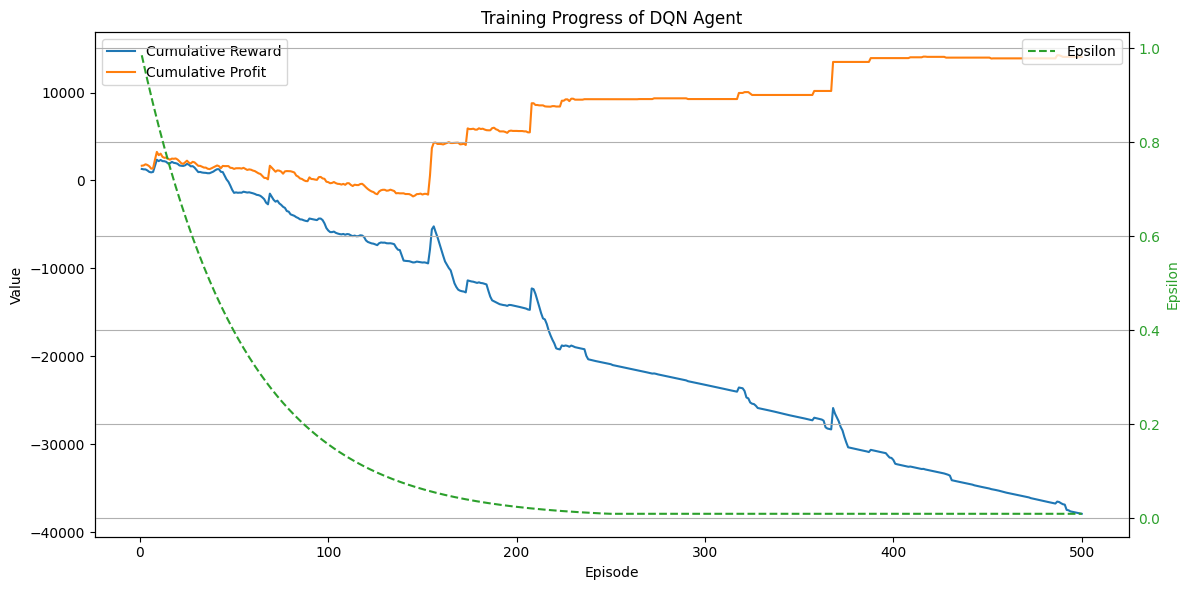

In [15]:
# Final results
print(f"\nFinal Total Profit (All Episodes): {sum(all_profits):.2f}")
print(f"Final Total Reward (All Episodes): {sum(all_rewards):.2f}")
print(f"Final Epsilon: {agent.epsilon:.4f}")

# Visualization
episodes = range(1, len(all_rewards) + 1)
cumulative_rewards = np.cumsum(all_rewards)
cumulative_profits = np.cumsum(all_profits)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot cumulative reward and profit
ax1.plot(episodes, cumulative_rewards, label="Cumulative Reward", color="tab:blue")
ax1.plot(episodes, cumulative_profits, label="Cumulative Profit", color="tab:orange")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Value")
ax1.legend(loc="upper left")

# Plot epsilon on second y-axis
ax2 = ax1.twinx()
epsilons = [max(agent.epsilon_min, agent.epsilon * (agent.epsilon_decay ** ep)) for ep in range(len(all_rewards))]
ax2.plot(episodes, all_epsilons, label="Epsilon", color="tab:green", linestyle="--")
ax2.set_ylabel("Epsilon", color="tab:green")
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc="upper right")

plt.title("Training Progress of DQN Agent")
plt.grid(True)
plt.tight_layout()
plt.show()

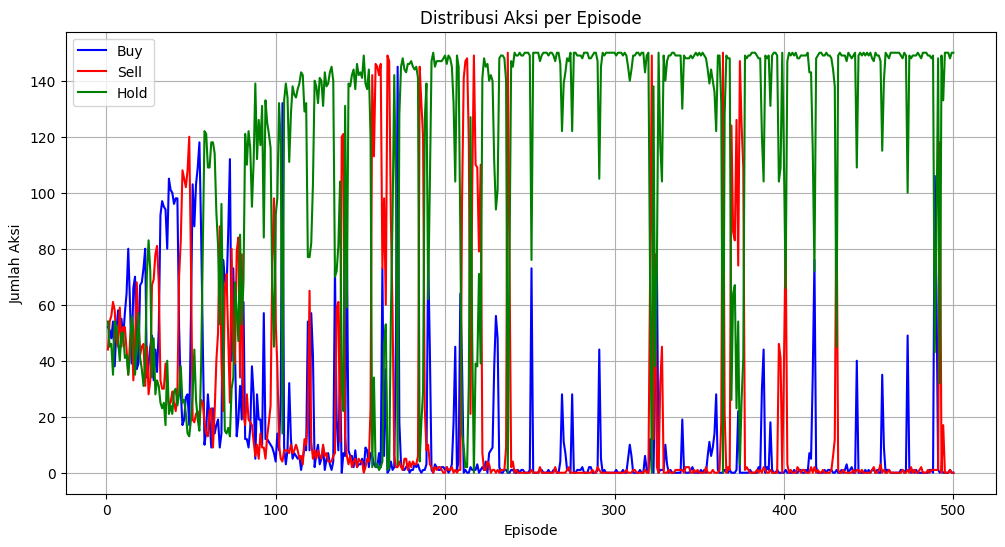

In [16]:
# Visualisasi distribusi aksi
plt.figure(figsize=(12, 6))
episodes = range(1, len(action_counts['buy']) + 1)
plt.plot(episodes, action_counts['buy'], label='Buy', color='blue')
plt.plot(episodes, action_counts['sell'], label='Sell', color='red')
plt.plot(episodes, action_counts['hold'], label='Hold', color='green')

plt.title("Distribusi Aksi per Episode")
plt.xlabel("Episode")
plt.ylabel("Jumlah Aksi")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Evaluasi di test set
test_env = DQNTradingEnv(X_test, window_size=5)
state = test_env.reset()
total_test_reward = 0
test_action_counter = {'buy': 0, 'sell': 0, 'hold': 0}
step = 0

test_rewards = []
test_profits = []
test_eps = []  # tetap 0 karena eksploitasi penuh

while True:
    # Full exploitation (tanpa epsilon)
    q_values = agent.model.predict(state[np.newaxis], verbose=0)
    action = np.argmax(q_values[0])

    # Logging Q-value
    print(f"Q-values: {q_values[0]} | Avg Q: {np.mean(q_values):.2f} | Max Q: {np.max(q_values):.2f}")

    # Hitung aksi
    if action == 0:
        test_action_counter['buy'] += 1
    elif action == 1:
        test_action_counter['sell'] += 1
    else:
        test_action_counter['hold'] += 1

    next_state, reward, done = test_env.step(action)
    total_test_reward += reward
    test_rewards.append(reward)
    test_profits.append(test_env.total_profit)
    test_eps.append(0)  # agent.epsilon = 0 saat test

    state = next_state
    step += 1

    if done:
        break

# Print hasil evaluasi
print("\n📊 Evaluasi di Test Set:")
print(f"Total Profit: {test_env.total_profit:.2f}%")
print(f"Total Reward: {total_test_reward:.2f}")
print(f"Total Steps: {step}")
print(f"Aksi - Buy: {test_action_counter['buy']}, Sell: {test_action_counter['sell']}, Hold: {test_action_counter['hold']}")

Q-values: [ -7.284962 -11.031018  -6.377589] | Avg Q: -8.23 | Max Q: -6.38
Q-values: [ -7.2651896 -10.99112    -6.360343 ] | Avg Q: -8.21 | Max Q: -6.36
Q-values: [ -7.2525835 -10.979035   -6.352644 ] | Avg Q: -8.19 | Max Q: -6.35
Q-values: [ -7.2546678 -10.9924     -6.3557143] | Avg Q: -8.20 | Max Q: -6.36
Q-values: [ -7.274153  -11.022653   -6.3707647] | Avg Q: -8.22 | Max Q: -6.37
Q-values: [ -7.2841725 -11.043071   -6.381112 ] | Avg Q: -8.24 | Max Q: -6.38
Q-values: [ -7.285833  -11.03986    -6.3806953] | Avg Q: -8.24 | Max Q: -6.38
Q-values: [ -7.2899275 -11.055902   -6.3870115] | Avg Q: -8.24 | Max Q: -6.39
Q-values: [ -7.2992    -11.069699   -6.3937874] | Avg Q: -8.25 | Max Q: -6.39
Q-values: [ -7.2824745 -11.036724   -6.3785334] | Avg Q: -8.23 | Max Q: -6.38
Q-values: [ -7.2783465 -11.032394   -6.3761578] | Avg Q: -8.23 | Max Q: -6.38
Q-values: [ -7.2701383 -11.020357   -6.369088 ] | Avg Q: -8.22 | Max Q: -6.37
Q-values: [ -7.2888656 -11.051784   -6.384866 ] | Avg Q: -8.24 | Ma

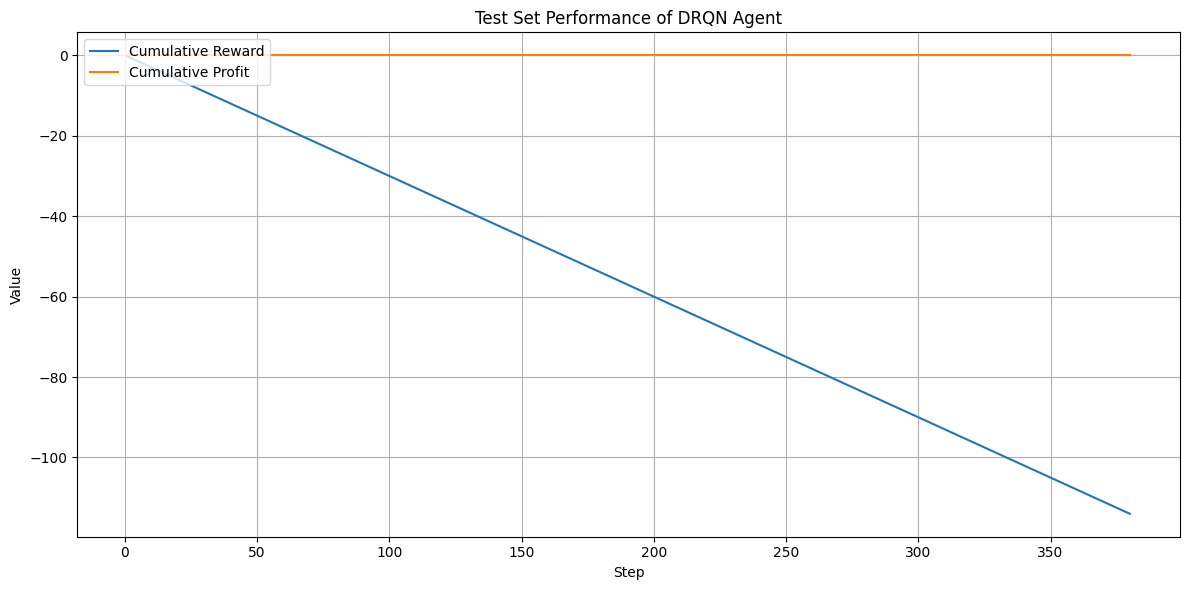

In [18]:
# Visualisasi hasil evaluasi di test set
steps = range(1, len(test_rewards) + 1)
cumulative_test_rewards = np.cumsum(test_rewards)
cumulative_test_profits = test_profits  # sudah cumulative dari env

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(steps, cumulative_test_rewards, label="Cumulative Reward", color="tab:blue")
ax1.plot(steps, cumulative_test_profits, label="Cumulative Profit", color="tab:orange")
ax1.set_xlabel("Step")
ax1.set_ylabel("Value")
ax1.set_title("Test Set Performance of DRQN Agent")
ax1.legend(loc="upper left")
ax1.grid(True)
plt.tight_layout()
plt.show()

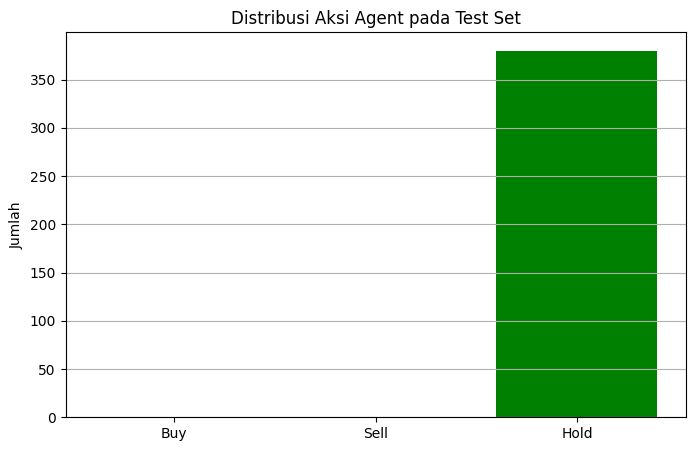

In [19]:
# Distribusi aksi test
labels = ['Buy', 'Sell', 'Hold']
counts = [
    test_action_counter['buy'],
    test_action_counter['sell'],
    test_action_counter['hold']
]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['blue', 'red', 'green'])
plt.title("Distribusi Aksi Agent pada Test Set")
plt.ylabel("Jumlah")
plt.grid(axis='y')
plt.show()